# MobileViT v2 for Drowsiness Detection

This notebook details the process of training a **MobileViT v2** classification model to detect driver drowsiness from images. This model is a state-of-the-art, lightweight, hybrid architecture combining the strengths of MobileNet v2 convolutions with Vision Transformers, making it ideal for efficient and accurate performance.

The workflow covers every stage from environment setup and data acquisition to model training, in-depth evaluation with specialized metrics, and model explainability using Grad-CAM.

### 1. Setup Environment

We begin by setting up our Python environment. To ensure the project is organized and reproducible, we first define a `HOME` constant for our working directory. This makes all file paths relative and the notebook portable.

In [1]:
import os
HOME = os.getcwd()
print(f"Project Home Directory: {HOME}")

Project Home Directory: /workspace


Next, we install the necessary libraries.
- `timm`: The core library for our MobileViTV2 model.
- `kagglehub`: To easily download datasets from Kaggle.
- `grad-cam`: For model explainability.
- Other libraries like `numpy`, `opencv-python`, and `matplotlib` are standard tools for data manipulation and visualization.

In [2]:
%pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --no-cache-dir kagglehub==0.3.12 huggingface_hub==0.33.1 pillow numpy opencv-python==4.11.0.86 matplotlib==3.10.3 seaborn==0.13.2 pandas==2.3.0 scikit-learn==1.7.0 grad-cam==1.5.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.6 MB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 370.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 392.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 398.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 402.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 459.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 152.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=04f644da18a32d70be64dcc862993ac971c965f4251db4be3b

In [4]:
%pip install --no-cache-dir timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 134.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [timm]1/2 [timm]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

DEVICE = "cpu"

print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current Device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
    DEVICE = torch.device("cuda")
print("Using DEVICE:", DEVICE)

CUDA available: True
Current Device: 0
Device name: NVIDIA RTX A5000
Using DEVICE: cuda


In [39]:
import os
HOME = os.getcwd()
# Define the path to store all the dataset files
DOWNLOAD_PATH = os.path.join(HOME, "downloads")
DATASET_PATH = os.path.join(HOME, "dataset")
VISUALIZATION_PATH = os.path.join(HOME, "visualizations")
MODEL_SAVE_PATH = os.path.join(HOME, "models")


# Create the directories if they don't exist
os.makedirs(DOWNLOAD_PATH, exist_ok=True)
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(VISUALIZATION_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(f"DOWNLOAD_PATH:{DOWNLOAD_PATH} \nDATASET_PATH:{DATASET_PATH} \nVISUALIZATION_PATH: {VISUALIZATION_PATH}\nMODEL_SAVE_PATH: {MODEL_SAVE_PATH}")

DOWNLOAD_PATH:/workspace/downloads 
DATASET_PATH:/workspace/dataset 
VISUALIZATION_PATH: /workspace/visualizations
MODEL_SAVE_PATH: /workspace/models


### 2. Download Dataset

We download two datasets. The primary dataset is used for training and validation, while a smaller, separate dataset is reserved for testing. Using a completely unseen test set provides a more realistic measure of the model's generalization performance.

**Datasets:**
*   [Driver Drowsiness Dataset (DDD)](https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd) (41,790 images)
*   [Driver Drowsiness Detection](https://universe.roboflow.com/tesi-jotog/driver-drowsiness-detection-7fvkf) (7,342 images)

In [7]:
import os
# Set environment variable before importing or using kagglehub
os.environ['KAGGLEHUB_CACHE'] = DOWNLOAD_PATH

import kagglehub

# Download the datasets from Kaggle
download_paths = [] 
dataset_urls = [
    'ismailnasri20/driver-drowsiness-dataset-ddd',
    'yasharjebraeily/drowsy-detection-dataset'
]

for url in dataset_urls:
    download_path = kagglehub.dataset_download(url)
    download_paths.append(download_path)
    
print(f'kaggle Datasets downloaded to: {download_paths}')

100%|██████████| 2.58G/2.58G [01:15<00:00, 36.7MB/s]

Extracting files...


100%|██████████| 14.2M/14.2M [00:01<00:00, 12.7MB/s]

Extracting files...


kaggle Datasets downloaded to: ['/workspace/downloads/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1', '/workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1']


Verify the structure of the downloaded files

In [8]:
for root, dirs, files in os.walk(DOWNLOAD_PATH):
    print(f'Found folder: {root} with {len(files)} files')

Found folder: /workspace/downloads with 0 files
Found folder: /workspace/downloads/datasets with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset with 1 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1 with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/NATURAL with 3050 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/

### 3. Organize Dataset

We organize the downloaded images into `train`, `val` (validation), and `test` folders. Within each of these, are subfolders named after our classes (e.g., `Drowsy`, `Non Drowsy`).

**Required Structure:**
```
dataset/
├── train/
│   ├── Drowsy/
│   └── Non Drowsy/
├── val/
│   ├── Drowsy/
│   └── Non Drowsy/
└── test/
    ├── Drowsy/
    └── Non Drowsy/
```

We Organize the dataset by doing these:
1.   Split the first dataset into train and val set (while keeping their labels intact).
2.   Merge the second dataset into a single test set (while keeping their labels intact)

In [9]:
# Organizes downloaded datasets into clean train/val/test structure, respecting original splits
import os
import shutil
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

def setup_directories(base_path, splits=['train', 'val', 'test'], classes=['Drowsy', 'Non Drowsy']):
    """Create clean directory structure"""
    base = Path(base_path)
    if base.exists():
        shutil.rmtree(base)
        print(f"Removed existing directory: {base}")
    
    for split in splits:
        for cls in classes:
            (base / split / cls).mkdir(parents=True, exist_ok=True)
    print("Created fresh train/val/test directories.")
    return {split: base / split for split in splits}

def process_yashar_dataset(download_path, dirs):
    """Process yasharjebraeily dataset - move test data, collect trainable files"""
    yashar_path = Path(download_path) / 'datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset'
    class_map = {'DROWSY': 'Drowsy', 'NATURAL': 'Non Drowsy'}
    trainable_files = []
    
    if not yashar_path.exists():
        print("Warning: 'yasharjebraeily' path not found.")
        return trainable_files
    
    print("Processing 'yasharjebraeily' dataset...")
    
    # Move test files and collect train files
    for split in ['test', 'train']:
        for src_class, dst_class in class_map.items():
            src_dir = yashar_path / split / src_class
            if not src_dir.exists():
                continue
                
            files = list(src_dir.glob('*.*'))
            if split == 'test':
                for i, f in enumerate(tqdm(files, desc=f'Moving yashar test/{src_class}')):
                    # Add unique prefix to test files to avoid collisions
                    new_name = f"yashar_test_{f.stem}_{i:04d}{f.suffix}"
                    shutil.move(str(f), dirs['test'] / dst_class / new_name)
            else:
                trainable_files.extend([(f, dst_class) for f in files])
    
    print(f"Finished 'yasharjebraeily'. Collected {len(trainable_files)} trainable files.")
    return trainable_files

def process_ismail_dataset(download_path, classes):
    """Process ismailnasri20 dataset - collect all files for training"""
    ismail_path = Path(download_path) / 'datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)'
    trainable_files = []
    
    if not ismail_path.exists():
        print("Warning: 'ismailnasri20' path not found.")
        return trainable_files
    
    print("Processing 'ismailnasri20' dataset...")
    for class_name in classes:
        src_dir = ismail_path / class_name
        if src_dir.exists():
            trainable_files.extend([(f, class_name) for f in src_dir.glob('*.*')])
    
    print(f"Finished 'ismailnasri20'. Collected {len(trainable_files)} trainable files.")
    return trainable_files

def create_train_val_split(trainable_files, dirs):
    """Split trainable files into train/val sets and move them"""
    if not trainable_files:
        print("No trainable files found to create train/val splits.")
        return
    
    print("Creating train/validation split...")
    filepaths, labels = zip(*trainable_files)
    
    train_files, val_files, train_labels, val_labels = train_test_split(
        filepaths, labels, test_size=0.15, random_state=42, stratify=labels
    )
    
    # Move files to destinations with unique naming
    for files, labels, split_dir in [(train_files, train_labels, 'train'), (val_files, val_labels, 'val')]:
        for i, (f, label) in enumerate(tqdm(zip(files, labels), desc=f'Moving files to {split_dir} set', total=len(files))):
            # Normalize label names
            dest_label = 'Drowsy' if label in ['DROWSY', 'Drowsy'] else 'Non Drowsy'
            # Create unique filename to avoid collisions
            file_path = Path(f)
            dataset_prefix = 'yashar_' if 'yasharjebraeily' in str(f) else 'ismail_'
            new_name = f"{dataset_prefix}{file_path.stem}_{i:04d}{file_path.suffix}"
            shutil.move(str(f), dirs[split_dir] / dest_label / new_name)

def print_summary(dirs):
    """Print final dataset statistics"""
    print("\n--- Dataset Organization Complete ---")
    for split_name, split_dir in dirs.items():
        drowsy_count = len(list((split_dir / 'Drowsy').iterdir()))
        nondrowsy_count = len(list((split_dir / 'Non Drowsy').iterdir()))
        print(f"{split_name.title()} Set: {drowsy_count} Drowsy | {nondrowsy_count} Non Drowsy")

# Main execution
print("--- Starting Dataset Organization ---")

# Setup
dirs = setup_directories(DATASET_PATH)
class_names = ['Drowsy', 'Non Drowsy']

# Process datasets and collect trainable files
yashar_files = process_yashar_dataset(DOWNLOAD_PATH, dirs)
ismail_files = process_ismail_dataset(DOWNLOAD_PATH, class_names)

# Create final splits
all_trainable = yashar_files + ismail_files
create_train_val_split(all_trainable, dirs)

# Summary
print_summary(dirs)

--- Starting Dataset Organization ---
Removed existing directory: /workspace/dataset
Created fresh train/val/test directories.
Processing 'yasharjebraeily' dataset...


Moving yashar test/DROWSY:   0%|          | 0/757 [00:00<?, ?it/s]

Moving yashar test/NATURAL:   0%|          | 0/726 [00:00<?, ?it/s]

Finished 'yasharjebraeily'. Collected 5859 trainable files.
Processing 'ismailnasri20' dataset...
Finished 'ismailnasri20'. Collected 41793 trainable files.
Creating train/validation split...


Moving files to train set:   0%|          | 0/40504 [00:00<?, ?it/s]

Moving files to val set:   0%|          | 0/7148 [00:00<?, ?it/s]


--- Dataset Organization Complete ---
Train Set: 21383 Drowsy | 19121 Non Drowsy
Val Set: 3774 Drowsy | 3374 Non Drowsy
Test Set: 757 Drowsy | 726 Non Drowsy


### 4. Clean Dataset

Before training, it is crucial to scan our dataset for problematic images. Corrupted files, oversized images, or low-quality images (e.g., solid black) can destabilize training and degrade model performance. This data cleaning step acts as a quality gate, ensuring our model learns from clean, valid data.

The script below uses multiprocessing to efficiently check every image for:
- Zero-byte or oversized files.
- Extreme dimensions (too large or too small).
- Low variance (e.g., solid color images).
- Corrupted image headers.

In [10]:
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
from pathlib import Path

# --- Configuration Constants ---
dry_run = True                         # Set to False to enable deletion
problem_images_log_file = "problematic_images.log"   # Log file name
num_workers = cpu_count()             # Adjust manually if needed
max_file_size_mb = 250  * 1024 * 1024 # 250mb
max_image_pixels = 178956970
min_width = 32
min_height = 32
low_variance_threshold = 10
supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')

def verify_image(file_path, delete_on_error=False):
    """Verify image against security and quality criteria."""
    try:
        file_size = os.path.getsize(file_path)
        if file_size == 0:
            return handle_problem(file_path, "File is zero bytes.", delete_on_error)

        if file_size > max_file_size_mb:
            return handle_problem(file_path, 
                f"File size ({file_size/1024**2:.1f}MB) exceeds limit ({max_file_size_mb/1024**2:.1f}MB).", 
                delete_on_error)

        with Image.open(file_path) as img:
            pixels = img.width * img.height

            if pixels > max_image_pixels:
                return handle_problem(file_path,
                    f"Dimensions ({img.width}x{img.height}={pixels/1e6:.1f}MP) exceed limit ({max_image_pixels/1e6:.1f}MP).",
                    delete_on_error)

            if img.width < min_width or img.height < min_height:
                return handle_problem(file_path,
                    f"Dimensions ({img.width}x{img.height}) below minimum ({min_width}x{min_height}).",
                    delete_on_error)

            img.load()
            img_array = np.array(img.convert('RGB'))
            if img_array.std() < low_variance_threshold:
                return handle_problem(file_path,
                    f"Low variance ({img_array.std():.1f}) - likely solid color.",
                    delete_on_error)

        return 'OK', file_path, "Verified successfully."

    except UnidentifiedImageError:
        return handle_problem(file_path, "Cannot identify image file - corrupted or invalid.", delete_on_error)
    except (IOError, OSError) as e:
        return handle_problem(file_path, f"IO/OS Error: {e}", delete_on_error)
    except Exception as e:
        return handle_problem(file_path, f"Unexpected error: {e}", delete_on_error)

def handle_problem(file_path, reason, delete_on_error):
    if delete_on_error:
        try:
            os.remove(file_path)
            return 'DELETED', file_path, reason
        except OSError as e:
            return 'PROBLEM', file_path, f"{reason} | Could not delete: {e}"
    return 'PROBLEM', file_path, reason

def get_image_files(root_dir):
    image_paths = [str(p) for p in Path(root_dir).rglob('*') if p.suffix.lower() in supported_extensions]
    print(f"Found {len(image_paths)} image files in '{root_dir}'")
    return image_paths


image_files = get_image_files(DATASET_PATH)
verify_func = partial(verify_image, delete_on_error=not dry_run)
problems = []
print(f"{'DRY-RUN MODE' if dry_run else 'DELETE MODE'}: Starting verification with {min(num_workers, len(image_files))} workers...")

with Pool(min(num_workers, len(image_files))) as pool, open(problem_images_log_file, 'w') as log_f:
    log_f.write(f"Dataset: {DATASET_PATH} | Mode: {'DRY-RUN' if dry_run else 'DELETE'}\n{'-'*50}\n")
    for result in tqdm(pool.imap_unordered(verify_func, image_files), 
                        total=len(image_files), desc="Verifying", unit="img"):
        if result[0] != 'OK':
            problems.append(result)
            log_f.write(f"[{result[0]}] {result[1]}: {result[2]}\n")

# Summary
ok_count = len(image_files) - len(problems)
deleted_count = sum(1 for r in problems if r[0] == 'DELETED')

print(f"\n--- Summary ---")
print(f"Total: {len(image_files)} | OK: {ok_count} | {'Problems' if dry_run else 'Deleted'}: {len(problems) if dry_run else deleted_count}")
print(f"Details logged to: {problem_images_log_file}")

Found 49135 image files in '/workspace/dataset'
DRY-RUN MODE: Starting verification with 128 workers...


Verifying: 100%|██████████| 49135/49135 [00:13<00:00, 3748.41img/s]



--- Summary ---
Total: 49135 | OK: 49125 | Problems: 10
Details logged to: problematic_images.log


All the datasets have now been organized.

In [11]:
for root, dirs, files in os.walk(DOWNLOAD_PATH):
    print(f'Found folder: {root} with {len(files)} files')

Found folder: /workspace/downloads with 0 files
Found folder: /workspace/downloads/datasets with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset with 1 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1 with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/NATURAL with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/DRO

In [12]:
# Count the total number of images in the dataset

for root, dirs, files in os.walk(DATASET_PATH):
    print(f'Found folder: {root} with {len(files)} files')
    
for root, dirs, files in os.walk(DATASET_PATH):
    print(f"Total {str(os.path.basename(root)).upper()} images : {len(files)}")

Found folder: /workspace/dataset with 0 files
Found folder: /workspace/dataset/test with 0 files
Found folder: /workspace/dataset/test/Non Drowsy with 726 files
Found folder: /workspace/dataset/test/Drowsy with 757 files
Found folder: /workspace/dataset/val with 0 files
Found folder: /workspace/dataset/val/Non Drowsy with 3374 files
Found folder: /workspace/dataset/val/Drowsy with 3774 files
Found folder: /workspace/dataset/train with 0 files
Found folder: /workspace/dataset/train/Non Drowsy with 19121 files
Found folder: /workspace/dataset/train/Drowsy with 21383 files
Total DATASET images : 0
Total TEST images : 0
Total NON DROWSY images : 726
Total DROWSY images : 757
Total VAL images : 0
Total NON DROWSY images : 3374
Total DROWSY images : 3774
Total TRAIN images : 0
Total NON DROWSY images : 19121
Total DROWSY images : 21383


#### Exploratory Data Analysis (EDA)
After cleaning, we perform a quick visual check of our dataset. Displaying a random grid of images helps us confirm that the classes are correct, the images are of reasonable quality, and our data loading process is working as expected.

In [13]:
import os
import math
import random

import cv2
import matplotlib.pyplot as plt

# Randomly selects images from dataset, creates a grid image, and saves it.
filepaths = []
dataset_grid_image = ""
no_of_images=20

# Use os.walk to find all image files in DATASET_PATH and subdirectories
for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(os.path.join(root, file))
            
if filepaths:
    num_to_sample = min(no_of_images, len(filepaths))
    images_to_visualize = random.sample(filepaths, num_to_sample)
    images = []
    for image_path in images_to_visualize:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image at {image_path}. Skipping.")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        title = f"{os.path.basename(os.path.dirname(image_path))}/{os.path.basename(image_path)}"
        images.append((image, title))

    
    if images:    
        # Determine grid size (e.g., for 5 images: 3x2 grid)
        grid_cols = math.ceil(math.sqrt(len(images)))
        grid_rows = math.ceil(len(images) / grid_cols)
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        axs = axs.flatten()
        for ax, (img, title) in zip(axs, images):
            ax.imshow(img)
            ax.set_title(title, fontsize=10)
            ax.axis("off")
        # Hide any unused subplots
        for ax in axs[len(images):]:
            ax.axis("off")
        plt.tight_layout()
        dataset_grid_image = os.path.join(VISUALIZATION_PATH, f'dataset_visualization_grid.png')
        plt.savefig(dataset_grid_image)
        plt.close(fig)
        print(dataset_grid_image) # it is an image path string

/workspace/visualizations/dataset_visualization_grid.png


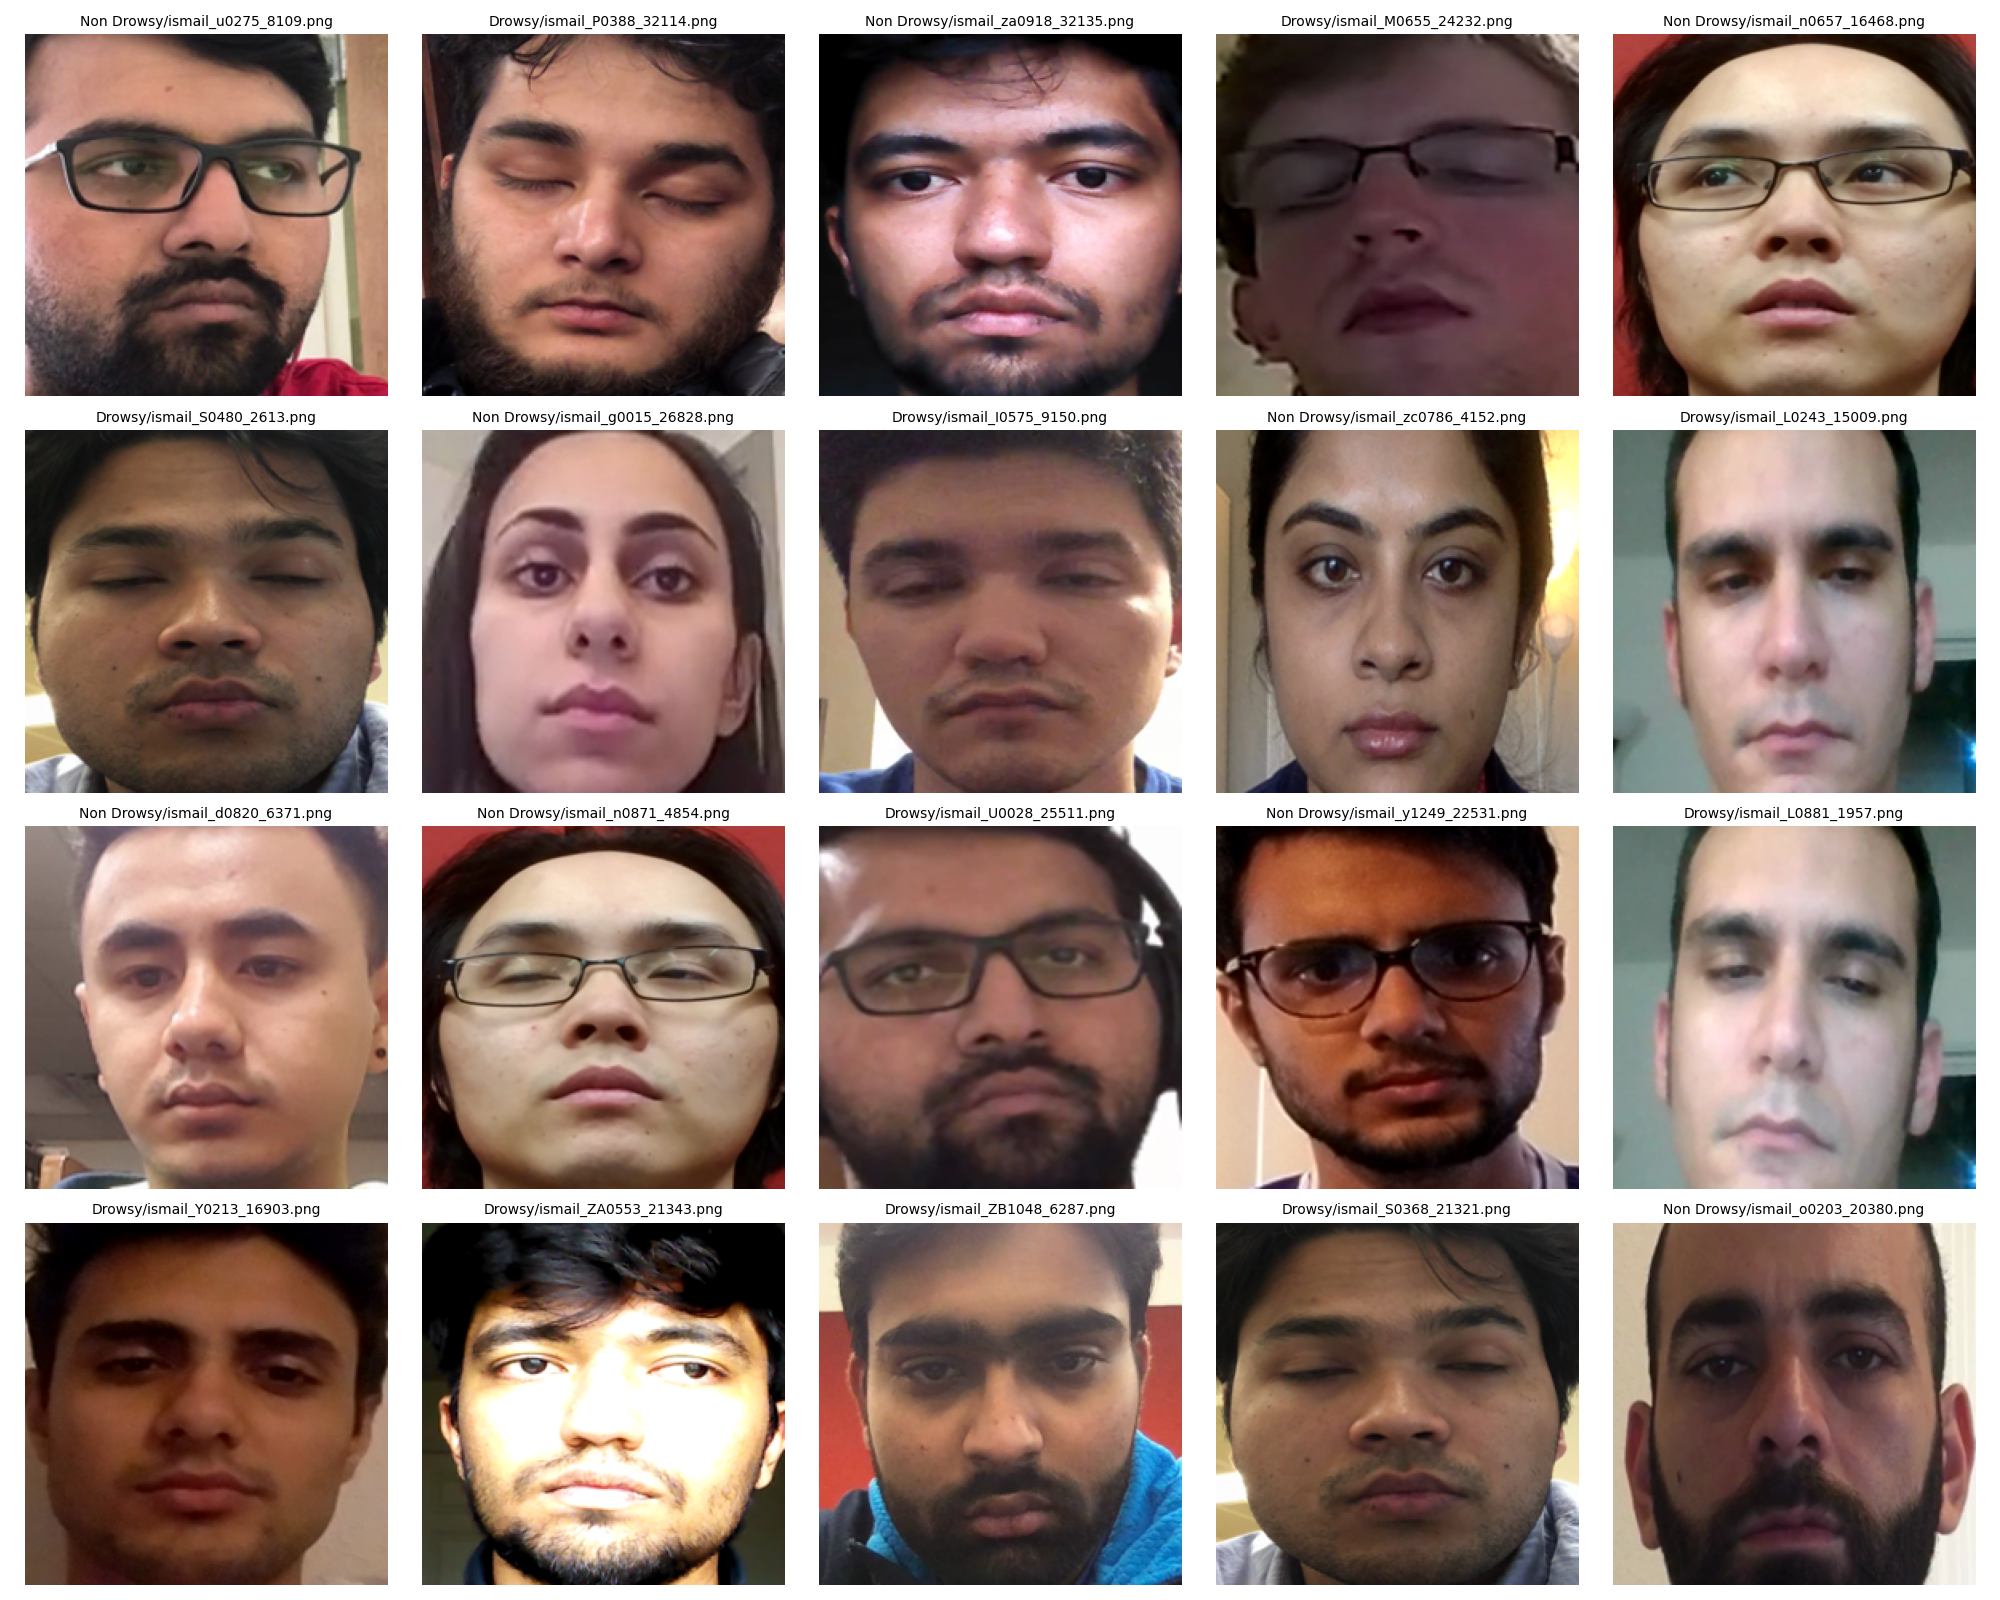

In [14]:
from IPython.display import Image as IPyImage

# Display the image
IPyImage(filename=dataset_grid_image, width=600)

#### Augmentation Visualization

PyTorch's `transforms` are used to apply a variety of random data augmentations to the training images in each epoch. These transformations (such as color shifts, rotations, scaling, and flipping) create a more diverse training set, which is a powerful technique to help the model generalize better and prevent overfitting.

In this step, we will visualize these augmentations. We'll take a sample image from our training set and repeatedly apply the transformation pipeline to it, displaying the results in a grid. This allows us to visually inspect the severity and variety of the augmentations and ensure they are appropriate for the task.

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HOME = os.getcwd()
DATASET_PATH = os.path.join(HOME, "dataset")

input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomResizedCrop(size=(input_size, input_size), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

val_test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


# --- 1. Load Datasets ---
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), transform=val_test_transform)

# --- 2. Create DataLoaders ---
BATCH_SIZE = 64 # A reasonable default, can be adjusted based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Class mapping: {train_dataset.class_to_idx}")
class_names = list(train_dataset.class_to_idx.keys())

Class mapping: {'Drowsy': 0, 'Non Drowsy': 1}


In [7]:
# Builds and saves visualizations of augmented images in grid images, using the dataset's transform pipeline.
import os
import math
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

# --- Define visualization path ---
VISUALIZATION_PATH = os.path.join(HOME, "visualizations")
os.makedirs(VISUALIZATION_PATH, exist_ok=True)

# Helper function to denormalize and prepare an image tensor for plotting
def denormalize_image(tensor_image):
    """Converts a normalized tensor image to a plottable numpy array."""
    # Use the same mean and std that were used for normalization in CELL 1
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    
    image_np = tensor_image.permute(1, 2, 0).cpu().numpy()
    # Reverse the normalization: (tensor * std) + mean
    image_np = image_np * std + mean
    image_np = np.clip(image_np, 0, 1)  # Clip values to [0, 1] for valid display
    return image_np

dataset = train_dataset #The dataset object with the attached transform.
num_images=4 #number of original images to augment and display.
augmentations_per_image=8 #number of augmented versions per original image.

num_images_to_show = min(num_images, len(dataset))
random_indices = random.sample(range(len(dataset)), num_images_to_show)
output_files = []

# Create a simple resize transform for displaying the original image consistently.
# It expects a PIL Image.
resize_for_display = transforms.Resize((input_size, input_size))

for i, image_idx in enumerate(random_indices):
    # FIX 1: Access the image path from dataset.samples, which is a list of (path, class_index) tuples.
    image_path = dataset.samples[image_idx][0]

    # Load image with OpenCV, then convert to RGB and finally to a PIL Image,
    # as torchvision transforms expect PIL Images.
    original_image_bgr = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)
    original_pil = Image.fromarray(original_image_rgb)

    # Create a grid for one original + multiple augmented images
    grid_size = math.ceil(math.sqrt(augmentations_per_image + 1))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 3, grid_size * 3))
    axes = axes.flatten()

    # Display the original image (resized for fair comparison using torchvision)
    resized_original = resize_for_display(original_pil)
    axes[0].imshow(resized_original)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Generate and display augmented images
    for j in range(augmentations_per_image):
        # The dataset's transform pipeline expects a PIL Image and returns a Tensor.
        augmented_tensor = dataset.transform(original_pil)
        # FIX 2: The denormalize_image function now correctly reverses the ImageNet normalization.
        augmented_image_np = denormalize_image(augmented_tensor)
        axes[j + 1].imshow(augmented_image_np)
        axes[j + 1].set_title(f"Augmented {j+1}")
        axes[j + 1].axis("off")

    # Hide any unused subplots
    for k in range(augmentations_per_image + 1, len(axes)):
        axes[k].axis("off")

    plt.tight_layout()
    output_path = os.path.join(VISUALIZATION_PATH, f'augmentation_grid_{i}.png')
    plt.savefig(output_path)
    plt.close(fig)
    output_files.append(output_path)

print(f"Saved {len(output_files)} augmentation visualizations to '{VISUALIZATION_PATH}'")

Saved 4 augmentation visualizations to '/workspace/visualizations'


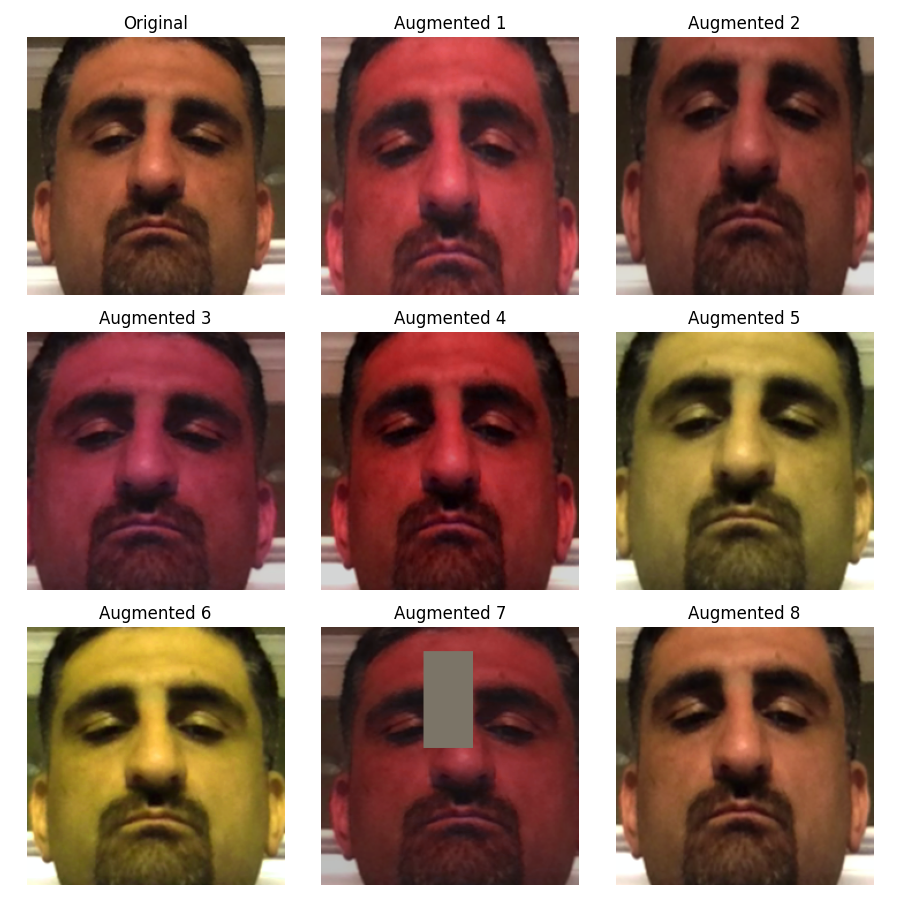

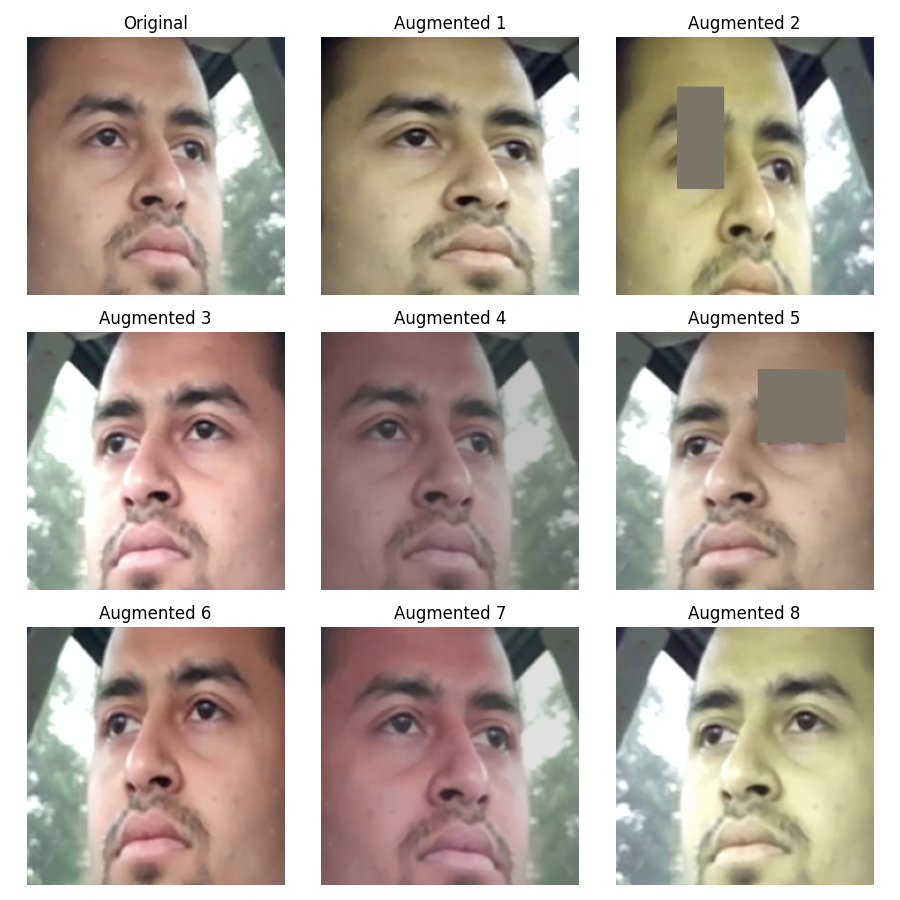

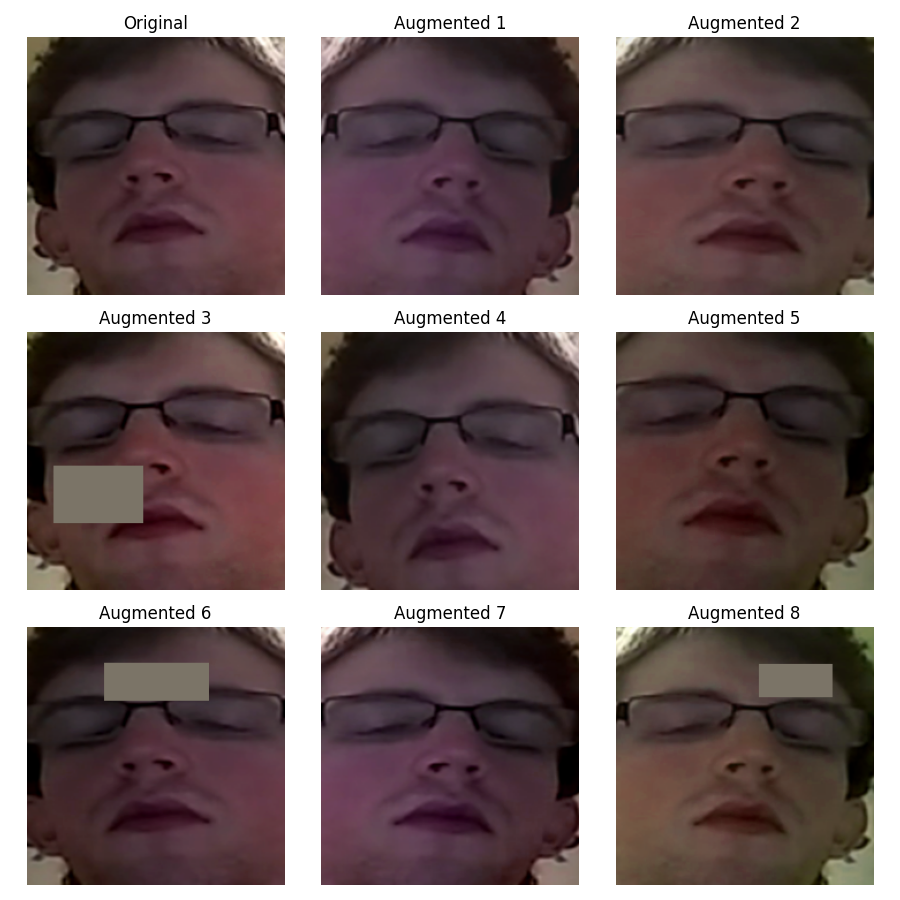

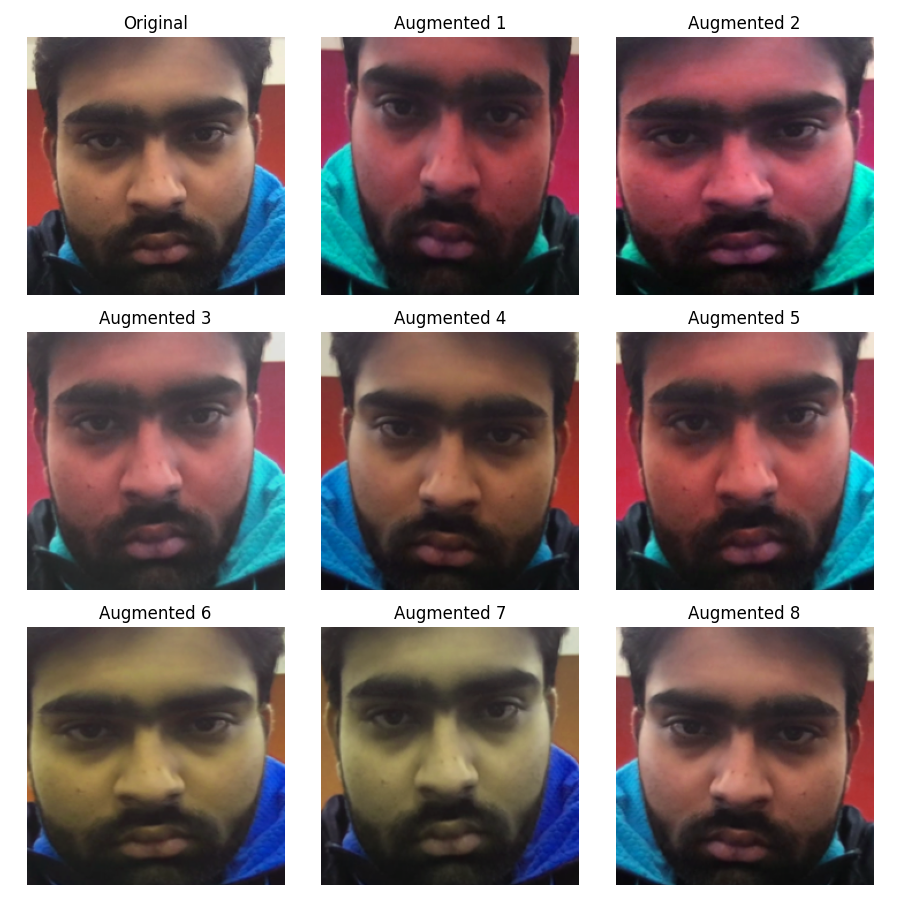

In [9]:
from IPython.display import Image as IPyImage, display

# Display the images
for image_path in output_files:
    display(IPyImage(filename=image_path, width=400))

### 5. Model Training

We use a standard PyTorch training workflow. The key components are:

**Key Training Components:**
- **Model**: A pre-trained `mobilevitv2_200` loaded from `timm`, with its final classification layer replaced to match our binary task (Drowsy vs. Non Drowsy).
- **DataLoader**: Efficiently loads data in batches from our structured `train`, `val`, and `test` directories using PyTorch's `ImageFolder`.
- **Loss Function**: `BCEWithLogitsLoss`, which is ideal for binary classification as it combines a Sigmoid activation and Binary Cross Entropy loss in one numerically stable function.
- **Optimizer**: Adam, a popular and effective optimization algorithm.
- **Scheduler**: `ExponentialLR` gradually reduces the learning rate during training, which can help the model settle into a better minimum.
- **Early Stopping**: A crucial technique to halt training if the validation loss doesn't improve for a specified number of epochs (`patience`), preventing overfitting and saving computational resources.

Load the Model

In [36]:
import timm
import torch
import torch.nn as nn

# --- 3. Initialize Model and Training Components ---
model = timm.create_model('mobilevitv2_200', pretrained=True, num_classes=2)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

print(f"Model: {model.default_cfg['architecture']}")
print(f"Classifier: {model.get_classifier()}")
print(f"Device: {next(model.parameters()).device}")

Model: mobilevitv2_200
Classifier: Linear(in_features=1024, out_features=2, bias=True)
Device: cuda:0


Train the model

In [37]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects = 0.0, 0
    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(torch.sum(preds == labels.data)/inputs.size(0)):.4f}")
    return running_loss / len(loader.dataset), running_corrects.double() / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(torch.sum(preds == labels.data)/inputs.size(0)):.4f}")
    return running_loss / len(loader.dataset), running_corrects.double() / len(loader.dataset)

print("Training Functions Loaded")

Training Functions Loaded


In [ ]:
# --- Main Training Loop with Early Stopping and CSV Logging ---

num_epochs = 300
patience = 20

best_val_acc = 0.0
patience_counter = 0
best_model_path = ""

history_csv_path = os.path.join(VISUALIZATION_PATH, "training_history.csv")
if os.path.exists(history_csv_path): 
    os.remove(history_csv_path)

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()

    print(f"Epoch {epoch+1} Summary: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    epoch_data = {'epoch': [epoch + 1], 'train_loss': [train_loss], 'train_acc': [train_acc.item()], 'val_loss': [val_loss], 'val_acc': [val_acc.item()]}
    pd.DataFrame(epoch_data).to_csv(history_csv_path, mode='a', header=not os.path.exists(history_csv_path), index=False)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_path = os.path.join(MODEL_SAVE_PATH, f"best_model.pt")
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation accuracy improved to {val_acc:.4f}. Saving model to {best_model_path}")
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epoch(s). Patience is {patience}.")

    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
        break

print("\nTraining complete.")


--- Epoch 1/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1 Summary: Train Loss: 0.0052, Train Acc: 0.9985 | Val Loss: 0.0023, Val Acc: 0.9993
Validation accuracy improved to 0.9993. Saving model to /workspace/models/best_model.pt

--- Epoch 2/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 2 Summary: Train Loss: 0.0051, Train Acc: 0.9984 | Val Loss: 0.0024, Val Acc: 0.9993
No improvement in validation accuracy for 1 epoch(s). Patience is 20.

--- Epoch 3/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3 Summary: Train Loss: 0.0033, Train Acc: 0.9991 | Val Loss: 0.0046, Val Acc: 0.9982
No improvement in validation accuracy for 2 epoch(s). Patience is 20.

--- Epoch 4/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4 Summary: Train Loss: 0.0020, Train Acc: 0.9994 | Val Loss: 0.0011, Val Acc: 0.9996
Validation accuracy improved to 0.9996. Saving model to /workspace/models/best_model.pt

--- Epoch 5/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5 Summary: Train Loss: 0.0009, Train Acc: 0.9997 | Val Loss: 0.0042, Val Acc: 0.9987
No improvement in validation accuracy for 1 epoch(s). Patience is 20.

--- Epoch 6/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6 Summary: Train Loss: 0.0035, Train Acc: 0.9989 | Val Loss: 0.0022, Val Acc: 0.9994
No improvement in validation accuracy for 2 epoch(s). Patience is 20.

--- Epoch 7/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7 Summary: Train Loss: 0.0008, Train Acc: 0.9998 | Val Loss: 0.0054, Val Acc: 0.9987
No improvement in validation accuracy for 3 epoch(s). Patience is 20.

--- Epoch 8/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8 Summary: Train Loss: 0.0013, Train Acc: 0.9995 | Val Loss: 0.0014, Val Acc: 0.9996
No improvement in validation accuracy for 4 epoch(s). Patience is 20.

--- Epoch 9/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9 Summary: Train Loss: 0.0004, Train Acc: 0.9999 | Val Loss: 0.0015, Val Acc: 0.9996
No improvement in validation accuracy for 5 epoch(s). Patience is 20.

--- Epoch 10/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10 Summary: Train Loss: 0.0010, Train Acc: 0.9997 | Val Loss: 0.0008, Val Acc: 0.9999
Validation accuracy improved to 0.9999. Saving model to /workspace/models/best_model.pt

--- Epoch 11/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11 Summary: Train Loss: 0.0005, Train Acc: 0.9999 | Val Loss: 0.0005, Val Acc: 0.9999
No improvement in validation accuracy for 1 epoch(s). Patience is 20.

--- Epoch 12/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12 Summary: Train Loss: 0.0004, Train Acc: 0.9999 | Val Loss: 0.0010, Val Acc: 0.9997
No improvement in validation accuracy for 2 epoch(s). Patience is 20.

--- Epoch 13/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13 Summary: Train Loss: 0.0006, Train Acc: 0.9999 | Val Loss: 0.0014, Val Acc: 0.9994
No improvement in validation accuracy for 3 epoch(s). Patience is 20.

--- Epoch 14/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14 Summary: Train Loss: 0.0003, Train Acc: 0.9999 | Val Loss: 0.0020, Val Acc: 0.9996
No improvement in validation accuracy for 4 epoch(s). Patience is 20.

--- Epoch 15/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15 Summary: Train Loss: 0.0008, Train Acc: 0.9998 | Val Loss: 0.0010, Val Acc: 0.9999
No improvement in validation accuracy for 5 epoch(s). Patience is 20.

--- Epoch 16/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16 Summary: Train Loss: 0.0004, Train Acc: 0.9999 | Val Loss: 0.0007, Val Acc: 0.9996
No improvement in validation accuracy for 6 epoch(s). Patience is 20.

--- Epoch 17/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17 Summary: Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 0.0006, Val Acc: 0.9996
No improvement in validation accuracy for 7 epoch(s). Patience is 20.

--- Epoch 18/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18 Summary: Train Loss: 0.0005, Train Acc: 0.9999 | Val Loss: 0.0008, Val Acc: 0.9997
No improvement in validation accuracy for 8 epoch(s). Patience is 20.

--- Epoch 19/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

Validating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19 Summary: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0007, Val Acc: 0.9994
No improvement in validation accuracy for 9 epoch(s). Patience is 20.

--- Epoch 20/300 ---


Training:   0%|          | 0/633 [00:00<?, ?it/s]

#### Training History Visualization

After training, we examine the logs to understand the model's learning progress and check for signs of overfitting (where training performance improves but validation performance stagnates or degrades).

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.read_csv(history_csv_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot Loss
ax1.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(history_df['epoch'], history_df['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history_df['epoch'], history_df['val_acc'], label='Validation Accuracy', marker='o')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# save plot as image
training_plot_image = os.path.join(VISUALIZATION_PATH, f'training_plot.png')

plt.tight_layout()
plt.savefig(training_plot_image)
plt.close(fig)

print(training_plot_image)

/workspace/visualizations/training_plot.png


Training Results Table

In [49]:
history_df 

epoch  train_loss  train_acc  val_loss   val_acc
0       1    0.005246   0.998543  0.002254  0.999301
1       2    0.005058   0.998445  0.002372  0.999301
2       3    0.003339   0.999062  0.004640  0.998181
3       4    0.001968   0.999432  0.001133  0.999580
4       5    0.000919   0.999679  0.004228  0.998741
5       6    0.003520   0.998914  0.002225  0.999440
6       7    0.000849   0.999802  0.005408  0.998741
7       8    0.001258   0.999531  0.001442  0.999580
8       9    0.000448   0.999877  0.001533  0.999580
9      10    0.001018   0.999679  0.000834  0.999860
10     11    0.000467   0.999852  0.000480  0.999860
11     12    0.000428   0.999877  0.001032  0.999720
12     13    0.000615   0.999852  0.001366  0.999440
13     14    0.000316   0.999901  0.002013  0.999580
14     15    0.000815   0.999802  0.000989  0.999860
15     16    0.000446   0.999852  0.000729  0.999580
16     17    0.000181   0.999975  0.000578  0.999580
17     18    0.000469   0.999926  0.000787  0.999720
18     19    0.000064   1.000000  0.000711  0.999440
19     20    0.000336   0.999926  0.001303  0.999580
20     21    0.000048   0.999975  0.000494  0.999580
21     22    0.000030   1.000000  0.000562  0.999860
22     23    0.000273   0.999926  0.000545  0.999720
23     24    0.000058   0.999975  0.000612  0.999720
24     25    0.000097   0.999975  0.001503  0.999580
25     26    0.000181   0.999975  0.000421  0.999860
26     27    0.000406   0.999926  0.000913  0.999580
27     28    0.000017   1.000000  0.000717  0.999580
28     29    0.000040   1.000000  0.000650  0.999580
29     30    0.000033   0.999975  0.000639  0.999580

Training Visualization

The plot shows the loss and accuracy curves for both training and validation sets over epochs.

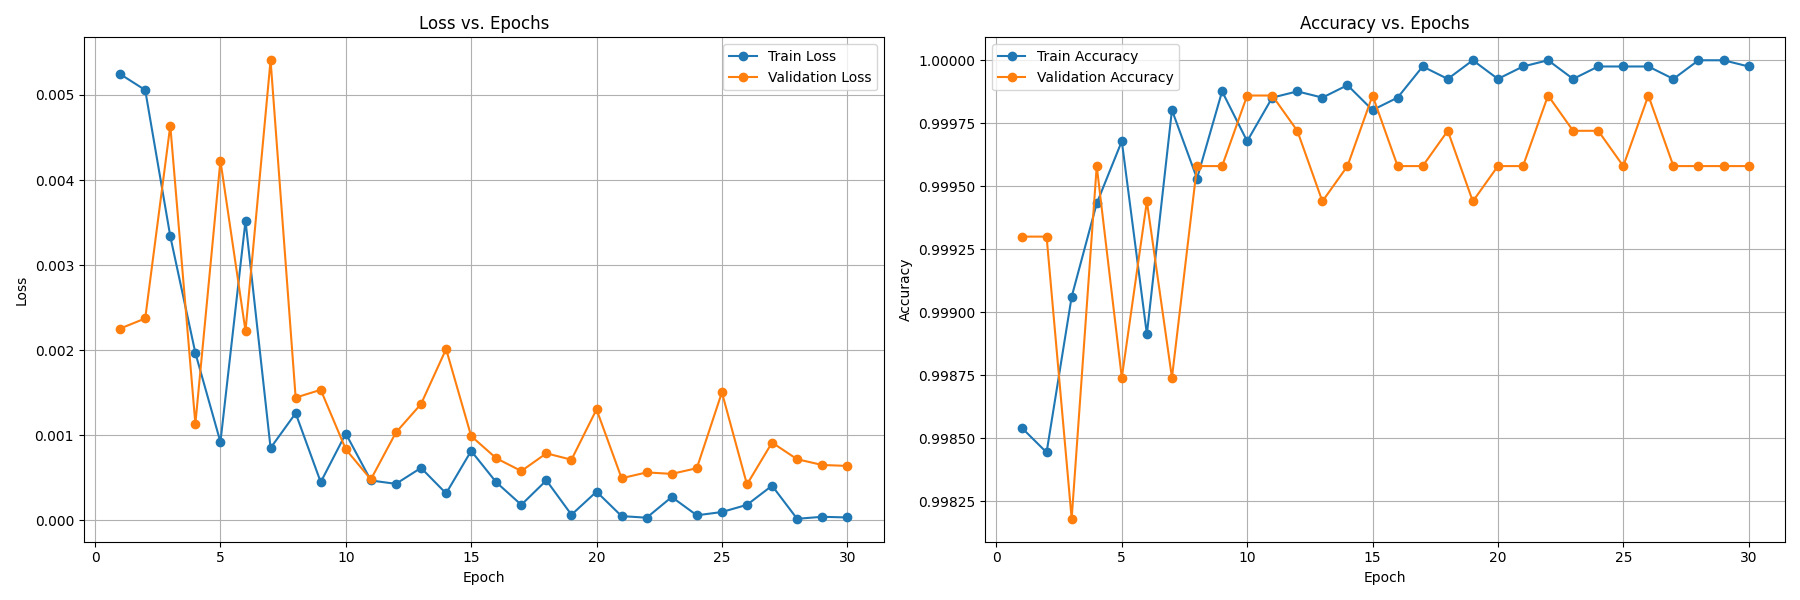

In [50]:
from IPython.display import Image as IPyImage

IPyImage(filename=training_plot_image, width=800)

### 6. Model Evaluation on Test Set

We perform an evaluation on the **unseen test set**, this provides the most honest assessment of the model's ability to generalize to new data.

#### Importance of Specialized Metrics

Standard accuracy can be misleading, especially in applications like drowsiness detection where the cost of different errors is not equal.

-   A **False Negative** (classifying a `Drowsy` driver as `Non Drowsy`) is far more dangerous than a **False Positive** (classifying a `Non Drowsy` driver as `Drowsy`).

To capture this, we use these metrics:

-   **APCER (Attack Presentation Classification Error Rate)**: The rate at which `Drowsy` drivers are misclassified as `Non Drowsy`. This is our critical safety metric. **A low APCER is paramount.**

-   **BPCER (Bona Fide Presentation Classification Error Rate)**: The rate at which `Non Drowsy` drivers are misclassified as `Drowsy`. This relates to usability (e.g., false alarms). 

-   **ACER (Average Classification Error Rate)**: The average of APCER and BPCER, giving a single score that balances the two types of errors.

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns


model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path} for final evaluation.")

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Standard Metrics ---
print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, pos_label=0):.4f} (Drowsy)") # Assuming Drowsy is class 0
print(f"Recall: {recall_score(y_true, y_pred, pos_label=0):.4f} (Drowsy)")
print(f"F1 Score: {f1_score(y_true, y_pred, pos_label=0):.4f} (Drowsy)")

# --- Drowsiness-Specific Metrics ---
print("\n--- Drowsiness Detection Metrics on Test Set ---")
cm = confusion_matrix(y_true, y_pred)
drowsy_idx = test_dataset.class_to_idx['Drowsy']
nondrowsy_idx = test_dataset.class_to_idx['Non Drowsy']

# APCER: Drowsy (attack) classified as Non-Drowsy (bona-fide).
# TN, FP, FN, TP -> Based on 'Non Drowsy' as the positive class (1)
# Drowsy=0 (Negative), Non-Drowsy=1 (Positive)
tn, fp, fn, tp = cm.ravel() 

drowsy_total = tn + fp
drowsy_misclassified_as_nondrowsy = fp
apcer = drowsy_misclassified_as_nondrowsy / drowsy_total if drowsy_total > 0 else 0.0

nondrowsy_total = fn + tp
nondrowsy_misclassified_as_drowsy = fn
bpcer = nondrowsy_misclassified_as_drowsy / nondrowsy_total if nondrowsy_total > 0 else 0.0

acer = (apcer + bpcer) / 2.0

print(f'APCER (Rate of Drowsy classified as Non Drowsy): {apcer:.4f}')
print(f'BPCER (Rate of Non Drowsy classified as Drowsy): {bpcer:.4f}')
print(f'ACER (Average Classification Error Rate): {acer:.4f}')

# --- Confusion Matrix Visualization ---
fig = plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')

plt.tight_layout()
confusion_matrix_image = os.path.join(VISUALIZATION_PATH, f'confusion_matrix_plot.png')
plt.savefig(confusion_matrix_image)
plt.close(fig)
print(f"confusion_matrix: {confusion_matrix_image}")

Loaded best model from /workspace/models/best_model.pt for final evaluation.


Evaluating on Test Set:   0%|          | 0/24 [00:00<?, ?it/s]


--- Test Set Performance ---
Accuracy: 0.9818
Precision: 1.0000 (Drowsy)
Recall: 0.9643 (Drowsy)
F1 Score: 0.9818 (Drowsy)

--- Drowsiness Detection Metrics on Test Set ---
APCER (Rate of Drowsy classified as Non Drowsy): 0.0357
BPCER (Rate of Non Drowsy classified as Drowsy): 0.0000
ACER (Average Classification Error Rate): 0.0178
confusion_matrix: /workspace/visualizations/confusion_matrix_plot.png


The confusion matrix gives us a clear breakdown of the model's performance on the validation set during training.

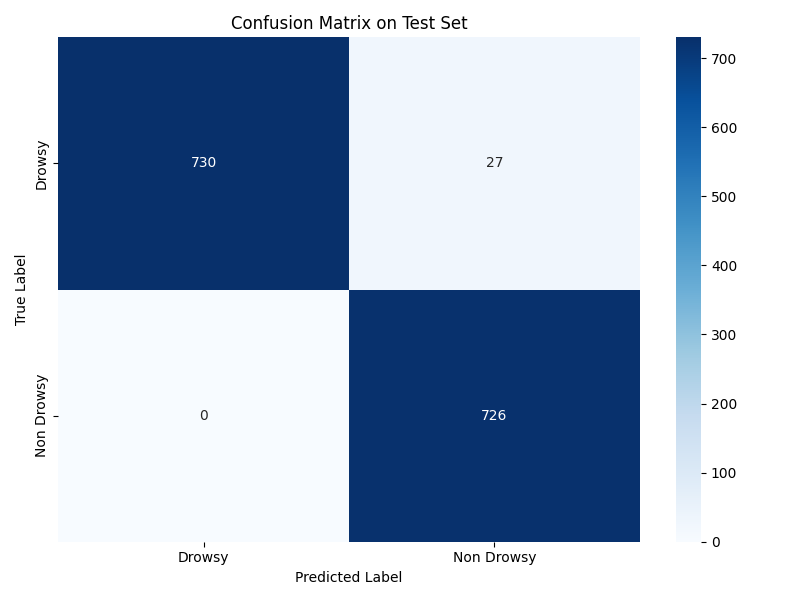

In [52]:
from IPython.display import Image as IPyImage

# Display the image
IPyImage(filename=f"{os.path.join(VISUALIZATION_PATH, f'confusion_matrix_plot.png')}", width=600)

### 7. Model Explainability with Grad-CAM

This section allows us to understand *why* the model makes certain predictions.

**Gradient-weighted Class Activation Mapping (Grad-CAM)** is a technique that produces a heatmap highlighting the regions in an image that were most influential for the model's decision. 

For a drowsiness detector, we expect Grad-CAM to highlight facial features like the eyes, mouth, or head position. This confirms the model is learning relevant patterns and not relying on spurious correlations in the background.

Based on the architecture, `model.conv_head` is the final convolutional layer before the global pooling and classifier. This is an excellent candidate for the target layer as it holds high-level spatial feature information.

In [55]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def denormalize_image(tensor_image):
    """Converts a normalized tensor image to a plottable numpy array."""
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    
    image_np = tensor_image.permute(1, 2, 0).cpu().numpy()
    image_np = image_np * std + mean
    image_np = np.clip(image_np, 0, 1)
    return image_np
    
generated_paths = []
num_samples=4
target_layers = [model.stages[-1][-1].conv_proj]

# Create Grad-CAM instance
cam = GradCAM(model=model, target_layers=target_layers)

# Select random samples from the test set
random_indices = random.sample(range(len(test_dataset)), num_samples)

for idx in random_indices:
    # Get sample and its true label
    img_tensor, true_label_idx = test_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
    
    # Define the target for Grad-CAM
    targets = [ClassifierOutputTarget(true_label_idx)]
    
    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # Prepare image for display (denormalize)
    rgb_img = denormalize_image(img_tensor)
    
    # Overlay CAM on the image
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # Get model's prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, pred_idx = torch.max(output, 1)
        
    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    true_label_name = class_names[true_label_idx]
    pred_label_name = class_names[pred_idx.item()]
    
    ax1.imshow(rgb_img)
    ax1.set_title(f"Original Image\nActual: {true_label_name}")
    ax1.axis('off')
    
    ax2.imshow(visualization)
    ax2.set_title(f"Grad-CAM Heatmap\nPredicted: {pred_label_name}")
    ax2.axis('off')
    
    # save plot as image
    grad_cam_image_name = f"grad_cam_sample_{idx}_{true_label_name}_{pred_label_name.lower().replace(' ', '')}.png"
    grad_cam_image = os.path.join(VISUALIZATION_PATH, grad_cam_image_name)

    plt.tight_layout()
    plt.savefig(grad_cam_image)
    plt.close(fig)
    generated_paths.append(grad_cam_image)

print(generated_paths)

['/workspace/visualizations/grad_cam_sample_64_Drowsy_drowsy.png', '/workspace/visualizations/grad_cam_sample_1087_Non Drowsy_nondrowsy.png', '/workspace/visualizations/grad_cam_sample_1443_Non Drowsy_nondrowsy.png', '/workspace/visualizations/grad_cam_sample_651_Drowsy_drowsy.png']


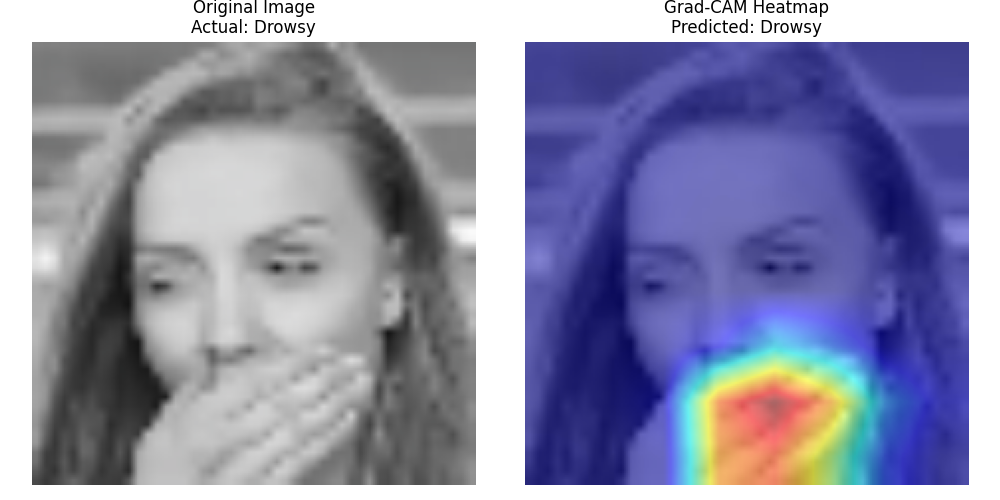

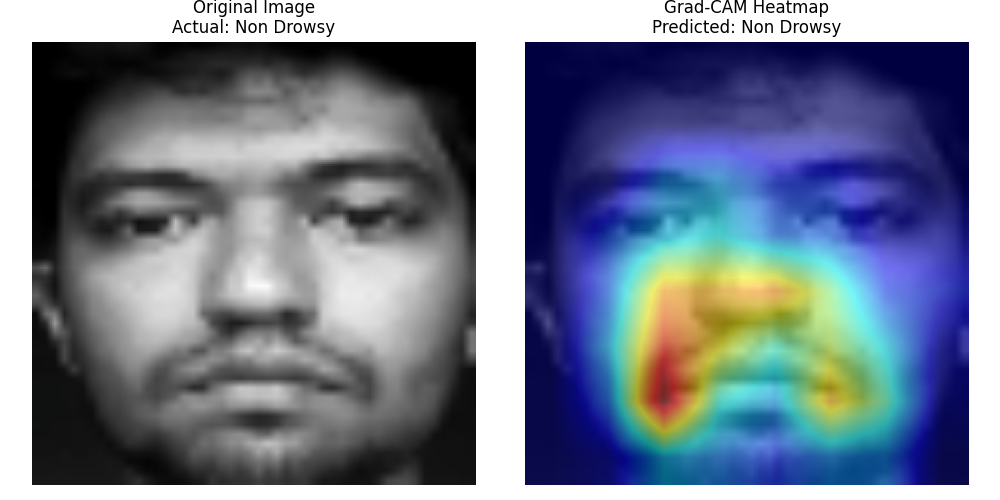

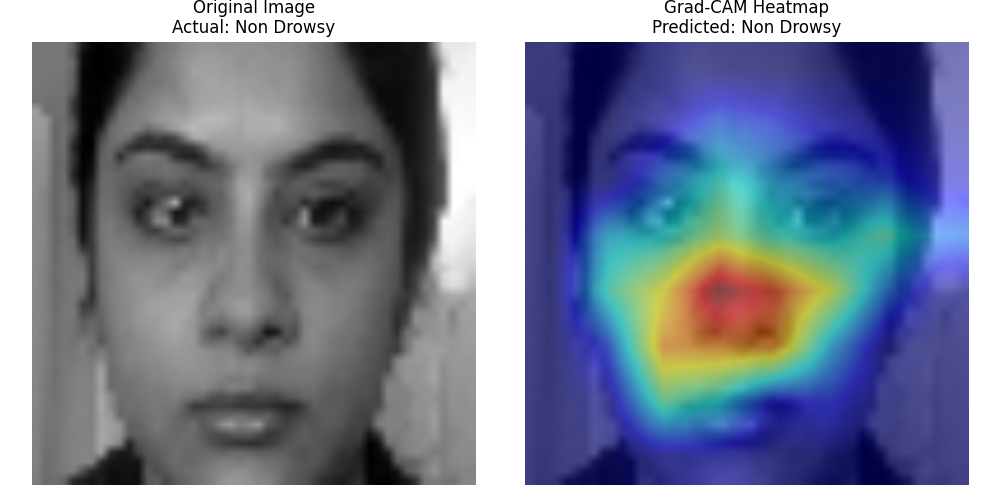

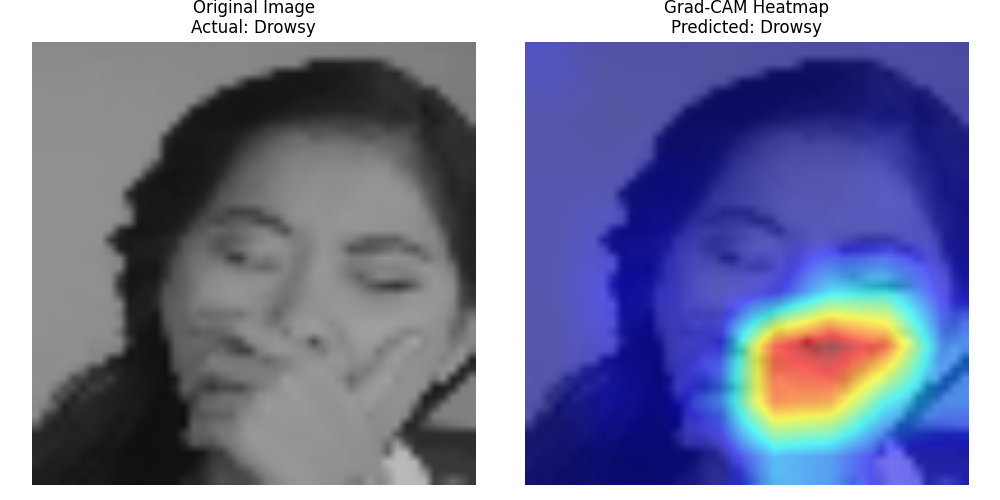

In [56]:
from IPython.display import Image as IPyImage

# Display the grad_cam images
for image_path in generated_paths:
    display(IPyImage(filename=image_path, width=600))

The heat maps demonstrate the model's focus on eye-closure, yawning, and head pose.